# Rao-blackwellized particle filter for Kalman filter

Based on https://github.com/probml/dynamax/blob/main/dynamax/slds/inference_test.py

In [1]:
import jax
import chex
import einops
import distrax
import seaborn as sns
import jax.numpy as jnp
import matplotlib.pyplot as plt
from functools import partial

In [2]:
%config InlineBackend.figure_format = "retina"

sns.set_palette("colorblind")
plt.rcParams["axes.spines.right"] = False
plt.rcParams["axes.spines.top"] = False
plt.rcParams["font.size"] = 12
# plt.rcParams["figure.figsize"] = (7.2, 4.0)
plt.rcParams["figure.figsize"] = (7.2, 3.0)

jnp.set_printoptions(linewidth=200)

In [3]:
plt.rcParams["text.usetex"] = True

## Model definitions

In [4]:
def draw_state(state, key, config):
    """
    Simulate one step of a system that evolves as
                A z_{t-1} + Bk + eps,
    where eps ~ N(0, Q).
    
    Parameters
    ----------
    val: tuple (int, jnp.array)
        (latent value of system, state value of system).
    params: RBPFParamsDiscrete
    key: PRNGKey
    """
    key_regime, key_latent, key_obs = jax.random.split(key, 3)
    probabilities = config.transition_matrix_regime[state.regime, :]
    logits = jnp.log(probabilities)
    regime_new = jax.random.categorical(key, logits)
    

    latent_new = config.transition_matrix_latent @ state.latent + config.drift[regime_new, :]
    latent_new = jax.random.multivariate_normal(key_latent, latent_new, config.dynamics_covariance)
    obs_new = jax.random.multivariate_normal(key_obs, config.projection_matrix @ latent_new, config.observation_covariance)

    state = state.replace(
        latent=latent_new,
        regime=regime_new
    )
    
    return state, (regime_new, latent_new, obs_new)

## Config

In [5]:
@chex.dataclass
class SSMConfig:
    transition_matrix_regime: chex.Array
    transition_matrix_latent: chex.Array # F
    projection_matrix: chex.Array # H
    dynamics_covariance: chex.Array # Q
    observation_covariance: chex.Array # R
    drift: chex.Array # B


@chex.dataclass
class RBPFKFState:
    latent: chex.Array
    regime: chex.Array

In [26]:
num_states = 3
num_particles = 10
state_dim = 4
emission_dim = 4

TT = 0.01
A = jnp.array([[1, TT, 0, 0],
            [0, 1, 0, 0],
            [0, 0, 1, TT],
            [0, 0, 0, 1]])


B1 = jnp.array([0, 0, 0, 0])
B2 = jnp.array([-1.225, -0.35, 1.225, 0.35])
B3 = jnp.array([1.225, 0.35,  -1.225,  -0.35])
B = jnp.stack([B1, B2, B3], axis=0)

Q = 2.0 * jnp.eye(4)

# Only observe position
R = jnp.diag(jnp.array([2, 2])) * 10
H = jnp.eye(4)[jnp.array([0,2])]

p_stay = 0.99
p_transition = (1 - p_stay) / 2
transition_matrix = jnp.array([
    [p_stay, p_transition, p_transition],
    [p_transition, p_stay, p_transition],
    [p_transition, p_transition, p_stay],
])
log_transition_matrix = jnp.log(transition_matrix)

In [27]:
config = SSMConfig(
    transition_matrix_regime=transition_matrix,
    transition_matrix_latent=A,
    projection_matrix=H,
    dynamics_covariance=Q,
    observation_covariance=R,
    drift=B
)

latent_init = jnp.zeros(4)
regime_init = 1
state_init = RBPFKFState(regime=regime_init, latent=latent_init)

In [28]:
key = jax.random.PRNGKey(31415)
key_sample, key_train = jax.random.split(key)

n_steps = 2000
keys = jax.random.split(key_sample, n_steps)

In [29]:
_step = partial(draw_state, config=config)
state_last, (hist_regime, hist_latent, hist_path) = jax.lax.scan(_step, state_init, keys)

In [30]:
colors = [sns.color_palette()[i] for i in hist_regime]

Text(0, 0.5, 'y-coord')

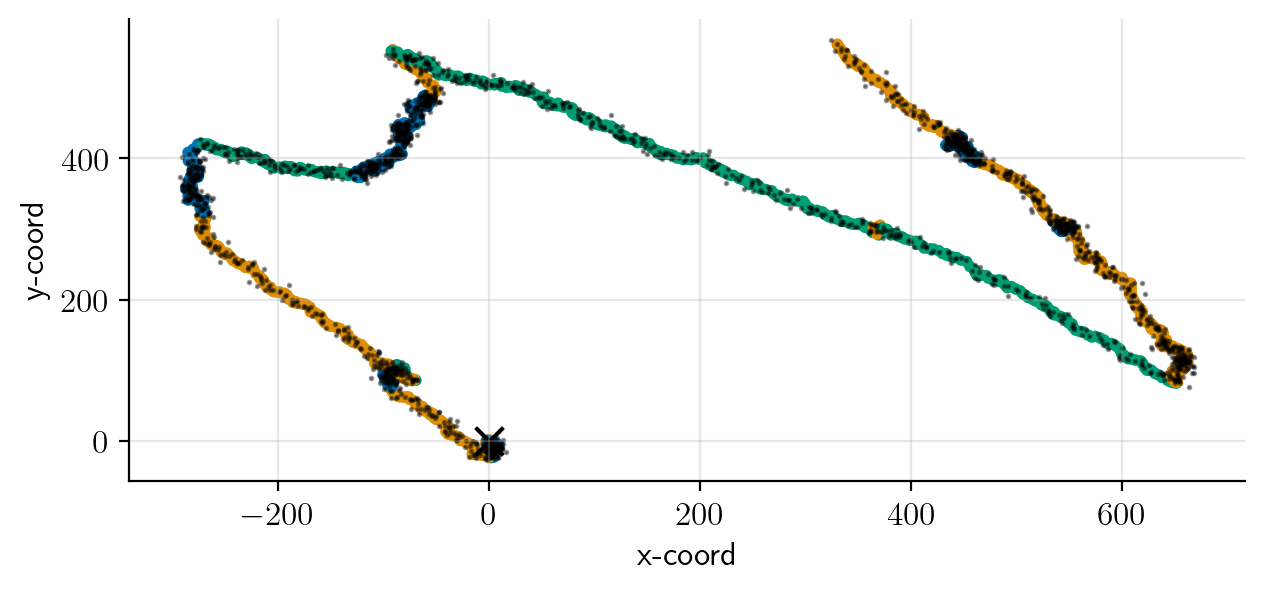

In [31]:
plt.scatter(hist_latent[:, 0], hist_latent[:, 2], c=colors, s=10)
plt.scatter(hist_path[:, 0], hist_path[:, 1], c="black", s=1, alpha=0.4)
plt.grid(alpha=0.3)
plt.scatter(0,0, c="black", marker="x", s=100)
plt.xlabel("x-coord")
plt.ylabel("y-coord")

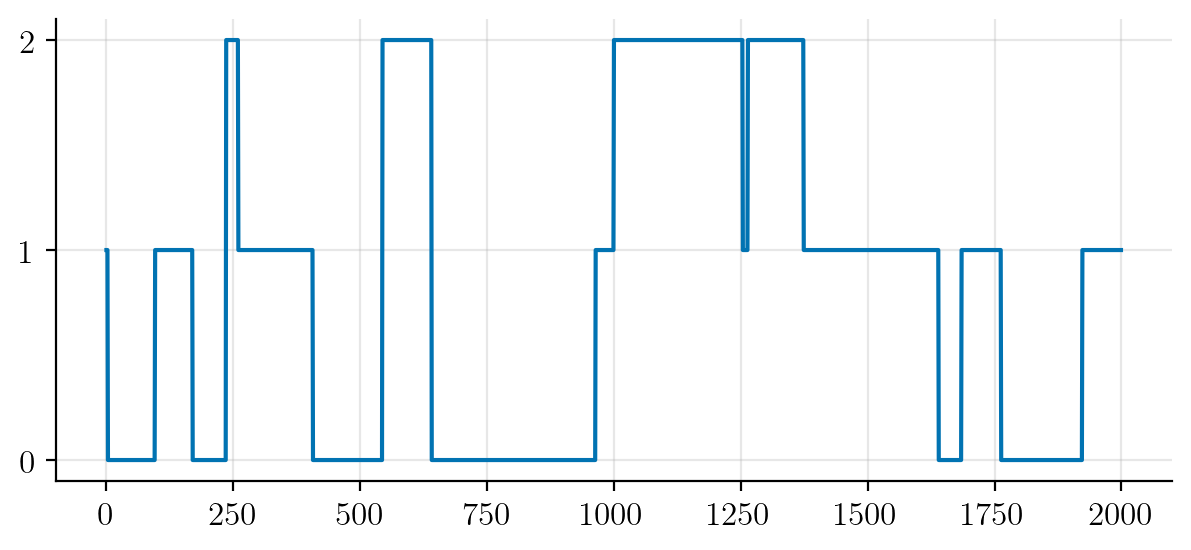

In [32]:
plt.plot(hist_regime)
plt.yticks([0, 1, 2])
plt.grid(alpha=0.3)

## RBPFilter!

In [33]:
@chex.dataclass
class KFConfig:
    H: jax.Array
    F: jax.Array
    Q: jax.Array
    R: jax.Array


@chex.dataclass
class KFState:
    mean: jax.Array
    cov: jax.Array
    regime: jax.Array # KF config

    @staticmethod
    def init(key, mean, cov, n_particles, n_configs):
        means = einops.repeat(mean, "m -> s m", s=n_particles)
        covs = einops.repeat(cov, "i j -> s i j", s=n_particles)
        regimes = jax.random.choice(key, n_configs, (n_particles,)) # uniform sample over configs
        
        return KFState(
            mean=means, 
            cov=covs,
            regime=regimes,
        )


def kf_step(y, B, bel, cfg):
    """
    Update belief and compute log-posterior-predictive
    """
    # Predict step
    mean_pred = cfg.F @ bel.mean + B
    cov_pred = cfg.F @ bel.cov @ cfg.F.T + cfg.Q

    # Innovation, variance, and Kalman gain
    yhat = cfg.H @ mean_pred
    err = y - yhat
    St = cfg.H @ cov_pred @ cfg.H.T + cfg.R
    Kt = jnp.linalg.solve(St, cfg.H @ cov_pred).T

    # Update step
    Kcov = jnp.eye(len(bel.mean)) - Kt @ cfg.H
    mean_update = mean_pred + Kt @ err
    cov_update = Kcov @ cov_pred @ Kcov.T + Kt @ cfg.R @ Kt.T

    bel = bel.replace(
        mean=mean_update,
        cov=cov_update
    )

    log_pp = distrax.MultivariateNormalFullCovariance(yhat, St).log_prob(y)

    return bel, log_pp

## RBPF with transition as proposal

In [34]:
@partial(jax.vmap, in_axes=(0, None, 0, None))
def kf_rbpf_step(key, y, bel, cfg):
    log_p_transition = log_transition_matrix[bel.regime]
    k_next = jax.random.categorical(key, log_p_transition)
    Bk = B[k_next]
    bel_update, log_pp = kf_step(y, Bk, bel, cfg)
    bel_update = bel_update.replace(regime=k_next)

    return bel_update, log_pp


def step(bel, xs, cfg):
    y, key = xs
    key_propagate, key_resample = jax.random.split(key)
    keys = jax.random.split(key_propagate, n_particles)
    bel_update, log_lls = kf_rbpf_step(keys, y, bel, cfg)
    
    ### Resample step ###
    # Resample indices according to log-likelihood
    new_ixs = jax.random.categorical(key_resample, log_lls, shape=(n_particles,))
    # Update new belief
    bel_update = jax.tree.map(lambda x: x[new_ixs], bel_update)

    return bel_update, (log_lls, bel_update.regime, bel_update.mean)

## Filter

In [41]:
n_particles = 200
n_regimes = 3

config = KFConfig(
    H=H,
    F=A,
    Q=Q,
    R=R
)

In [42]:
key_init, key_eval = jax.random.split(key_train)

In [43]:
mean_init = jnp.zeros(4)
cov_init = jnp.eye(4) * 1.0
keys = jax.random.split(key_eval, n_steps)
bel_init = KFState.init(key_train, mean_init, cov_init, n_particles, n_regimes)

Xs = (hist_path, keys)
_step = partial(step, cfg=config)
bel_final, (hist_ll, hist_regimes, hist_mean) = jax.lax.scan(_step, bel_init, Xs)

In [44]:
log_weight = hist_ll - jax.nn.logsumexp(hist_ll, axis=1, keepdims=True)
weights = jnp.exp(log_weight)

## Evaluating performance

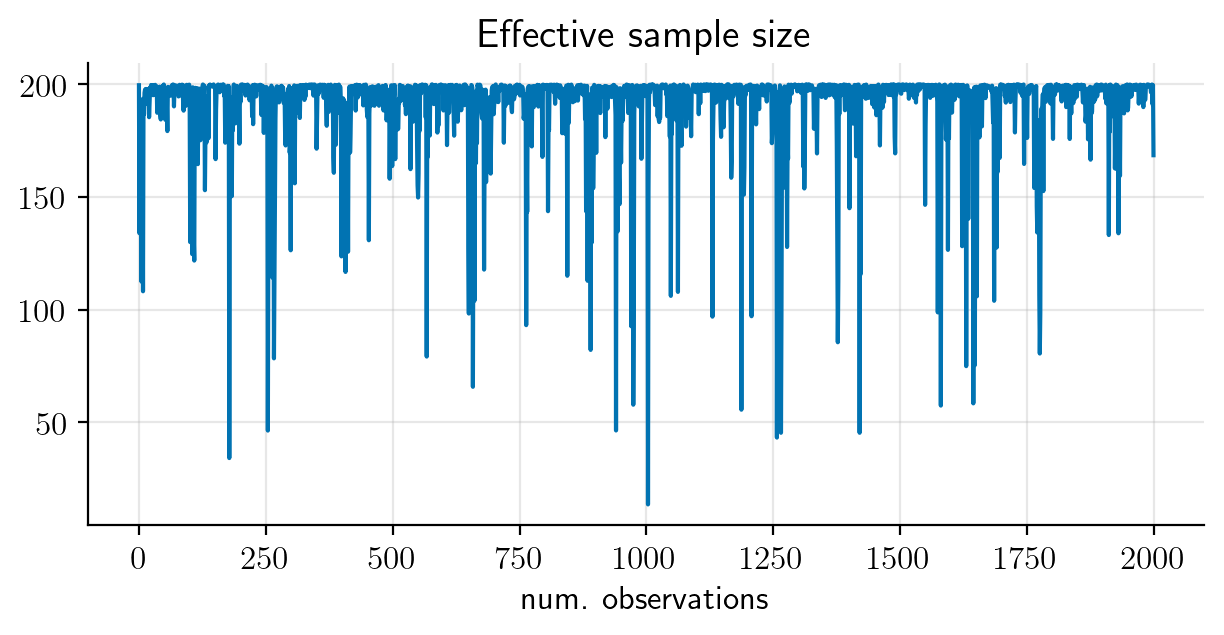

In [61]:
# Effective sample size
plt.title("Effective sample size")
ess = 1 / jnp.sum(weights ** 2, axis=1)
plt.plot(ess)
plt.xlabel("num. observations")
plt.grid(alpha=0.3)

In [62]:
ohe_regimes = jax.nn.one_hot(hist_regimes, 3)
weighted_regimes = jnp.einsum("tso,ts->to", ohe_regimes, weights)

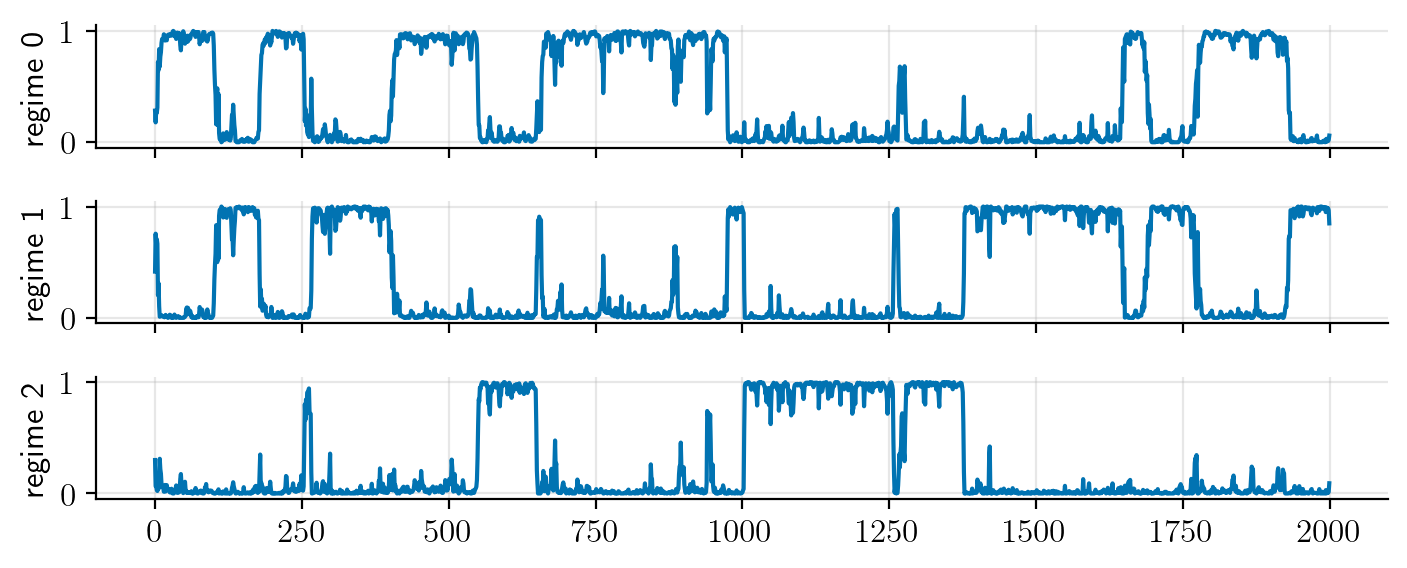

In [70]:
fig, axs = plt.subplots(3, 1, sharex=True)
for i, ax in enumerate(axs):
    ax.plot(weighted_regimes[:, i])
    ax.set_ylabel(f"regime {i}")
    ax.grid(alpha=0.3)
plt.tight_layout()

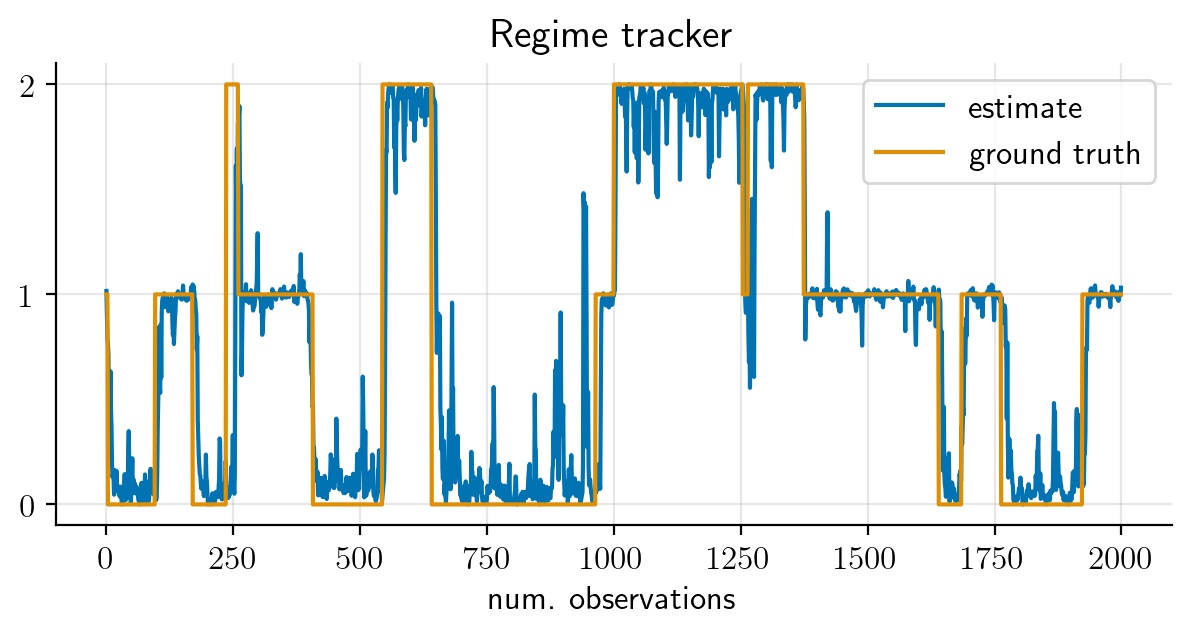

In [71]:
plt.plot((hist_regimes * weights).sum(axis=1), label="estimate")
plt.plot(hist_regime, label="ground truth")
plt.legend()
plt.yticks([0, 1, 2])
plt.xlabel("")
plt.xlabel("num. observations")
plt.title("Regime tracker")
plt.grid(alpha=0.3)